In [1]:
import geopandas as gpd
import pandas as pd


In [2]:
shapefile_path = "UScounties.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.head())

                NAME  STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  \
0  Lake of the Woods   Minnesota         27       077  27077   
1              Ferry  Washington         53       019  53019   
2            Stevens  Washington         53       065  53065   
3           Okanogan  Washington         53       047  53047   
4       Pend Oreille  Washington         53       051  53051   

                                            geometry  
0  POLYGON ((-95.34283 48.54668, -95.34105 48.715...  
1  POLYGON ((-118.85163 47.94956, -118.84846 48.4...  
2  POLYGON ((-117.43883 48.04412, -117.54219 48.0...  
3  POLYGON ((-118.97209 47.93915, -118.97406 47.9...  
4  POLYGON ((-117.43858 48.99992, -117.03205 48.9...  


In [3]:
covid_data = pd.read_csv("covidData2021-2022.csv")
print(covid_data.head())

         date     county       state     fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061.0      1     0.0
1  2020-01-22  Snohomish  Washington  53061.0      1     0.0
2  2020-01-23  Snohomish  Washington  53061.0      1     0.0
3  2020-01-24       Cook    Illinois  17031.0      1     0.0
4  2020-01-24  Snohomish  Washington  53061.0      1     0.0


In [4]:
# Normalize FIPS codes
gdf['FIPS'] = gdf['FIPS'].astype(str).str.zfill(5)
covid_data['fips'] = covid_data['fips'].fillna(0).astype(int).astype(str).str.zfill(5)

# Remove entries where FIPS code was originally NaN (now '00000')
covid_data = covid_data[covid_data['fips'] != '00000']

# Create a combined key for merging (County, State)
gdf['county_state'] = gdf['NAME'] + ', ' + gdf['STATE_NAME']
covid_data['county_state'] = covid_data['county'].str.strip() + ', ' + covid_data['state'].str.strip()


In [5]:
# Merge datasets on the combined county and state name key
combined_data = pd.merge(gdf, covid_data, on='county_state', how='left')


In [6]:
# Remove rows with missing COVID-19 data
cleaned_data = combined_data.dropna(subset=['date', 'cases', 'deaths'])

# Verify the data integrity
print("Sample data from the cleaned dataset:")
print(cleaned_data.sample(5))
print("\nSize of the dataset after cleanup:")
print(cleaned_data.shape)


Sample data from the cleaned dataset:
            NAME    STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  \
475144   Bristol  Rhode Island         44       001  44001   
387835    Otsego      New York         36       077  36077   
1685631   Howard      Arkansas         05       061  05061   
2292193   Lapeer      Michigan         26       087  26087   
618690     Adams       Indiana         18       001  18001   

                                                  geometry  \
475144   POLYGON ((-71.36739 41.74135, -71.31933 41.772...   
387835   POLYGON ((-75.21293 42.88528, -75.21250 42.860...   
1685631  POLYGON ((-93.95522 33.75314, -93.96940 33.807...   
2292193  POLYGON ((-83.10278 42.89238, -83.45570 42.885...   
618690   POLYGON ((-85.07392 40.58866, -85.07806 40.931...   

                  county_state        date   county         state   fips  \
475144   Bristol, Rhode Island  2021-11-29  Bristol  Rhode Island  44001   
387835        Otsego, New York  2021-08-21   Otsego      New Yor

In [7]:
# Check if any missing data remains in critical columns
if cleaned_data.isna().any(axis=1).sum() == 0:
    print("No missing data in critical columns.")
else:
    print("There are still rows with missing data.")


No missing data in critical columns.


In [21]:
# Check for negative values in 'cases' and 'deaths'
if (cleaned_data['cases'] < 0).any() or (cleaned_data['deaths'] < 0).any():
    print("Warning: There are negative values in the 'cases' or 'deaths' columns.")
else:
    print("No negative values in 'cases' or 'deaths' columns.")


No negative values in 'cases' or 'deaths' columns.


In [22]:
# Convert 'STATE_FIPS' and 'CNTY_FIPS' to categorical as they have limited unique values
cleaned_data['STATE_FIPS'] = cleaned_data['STATE_FIPS'].astype('category')
cleaned_data['CNTY_FIPS'] = cleaned_data['CNTY_FIPS'].astype('category')

# Convert 'cases' and 'deaths' to integers if they aren't already
cleaned_data['cases'] = cleaned_data['cases'].astype(int)
cleaned_data['deaths'] = cleaned_data['deaths'].astype(int)

print("Data types after conversion:")
print(cleaned_data.dtypes)


Data types after conversion:
NAME                       object
STATE_NAME                 object
STATE_FIPS               category
CNTY_FIPS                category
FIPS                       object
geometry                 geometry
county_state               object
date               datetime64[ns]
county                     object
state                      object
fips                       object
cases                       int64
deaths                      int64
next_week_cases           float64
week                       UInt32
date_next_week     datetime64[ns]
dtype: object


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarni

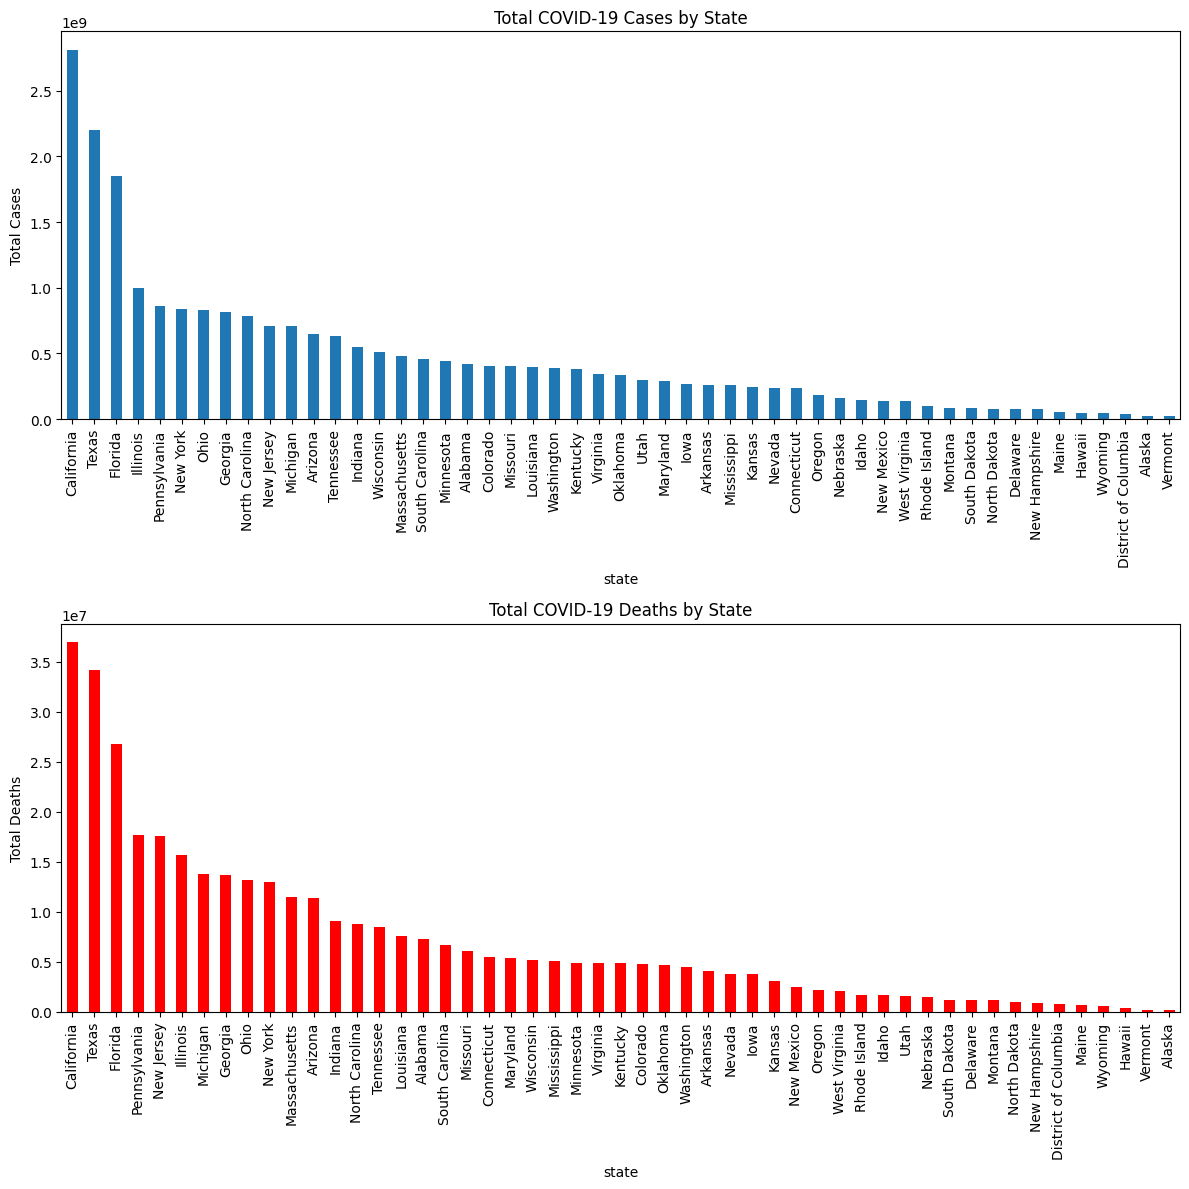

In [23]:
import matplotlib.pyplot as plt

# Group data by state and sum cases and deaths
state_summary = cleaned_data.groupby('state')[['cases', 'deaths']].sum().reset_index()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
state_summary.sort_values('cases', ascending=False).plot(x='state', y='cases', kind='bar', ax=ax[0], legend=False)
ax[0].set_title('Total COVID-19 Cases by State')
ax[0].set_ylabel('Total Cases')

state_summary.sort_values('deaths', ascending=False).plot(x='state', y='deaths', kind='bar', ax=ax[1], color='red', legend=False)
ax[1].set_title('Total COVID-19 Deaths by State')
ax[1].set_ylabel('Total Deaths')

plt.tight_layout()
plt.show()
